In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# Load the file
file_path = r"F:\programming\final_circuit_table.txt"

# Read lines that contain table data
with open(file_path, 'r', encoding='utf-8') as file:
    lines = [line.strip() for line in file if line.strip().startswith('|')]

# Parse table content
rows = [line.split('|')[1:-1] for line in lines]
rows = [[cell.strip() for cell in row] for row in rows]

# Extract header and data
header = rows[0]
all_data = pd.DataFrame(rows[1:], columns=header)

# Drop the first column (Circuit #)
data = all_data.iloc[:, 1:].copy()

# Convert to numeric where applicable
for col in data.columns[:-1]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop rows with NaNs
data = data.dropna()

# Features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Filter top 10 simulators
top_10_simulators = y.value_counts()[y.value_counts() >= 2].head(5).index
mask = y.isin(top_10_simulators)
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("Top 10 simulators selected:", list(top_10_simulators))

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
# Train classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.4f" % acc)

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5)
print("Cross-validated Accuracy: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))


Top 10 simulators selected: ['ibmq_sherbrooke', 'ibmq_prague', 'ibmq_quebec', 'ibmq_marrakesh', 'ibmq_peekskill']
Test Accuracy: 0.2603
Cross-validated Accuracy: 0.2805 ± 0.0071


In [42]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train XGBoost
model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train_enc)
y_pred = model.predict(X_test)
print("XGBoost Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


XGBoost Accuracy: 0.2644


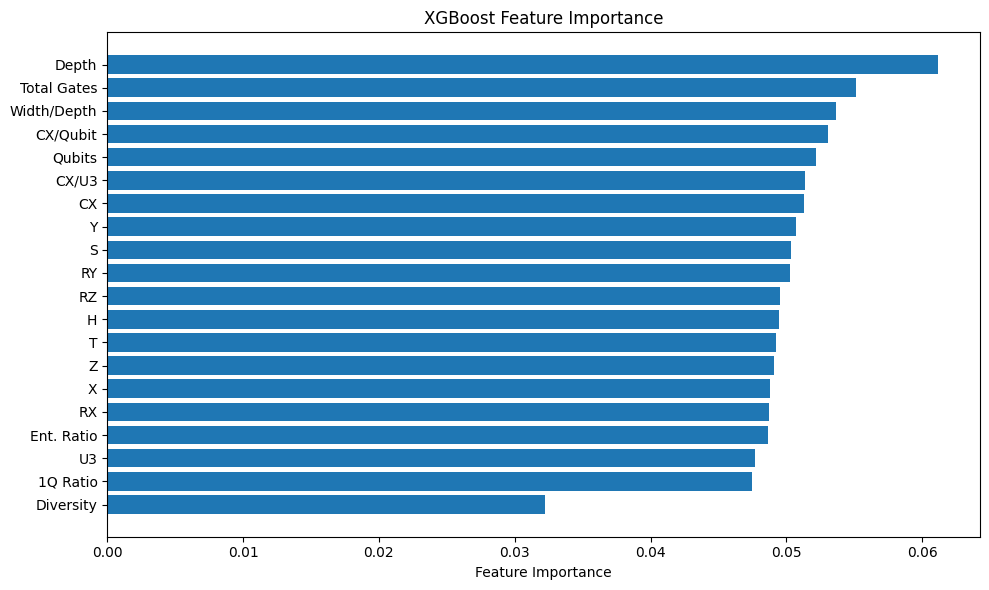

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from XGBoost
importances = model.feature_importances_
feature_names = X.columns

# Sort and plot
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


In [44]:
print(y.value_counts(normalize=True))


Best Simulator
ibmq_sherbrooke    0.266893
ibmq_prague        0.266068
ibmq_quebec        0.193454
ibmq_marrakesh     0.175850
ibmq_peekskill     0.097735
Name: proportion, dtype: float64


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assume X and y are already defined
scaler = StandardScaler()
X_scaled_reduced = scaler.fit_transform(X)  # scale your input features


# Train/test split (already scaled: X_scaled_reduced)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_reduced, y, test_size=0.2, random_state=42)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train logistic regression
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train_enc)

# Predict and evaluate
y_pred = logreg.predict(X_test)
print("Logistic Regression Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.2970


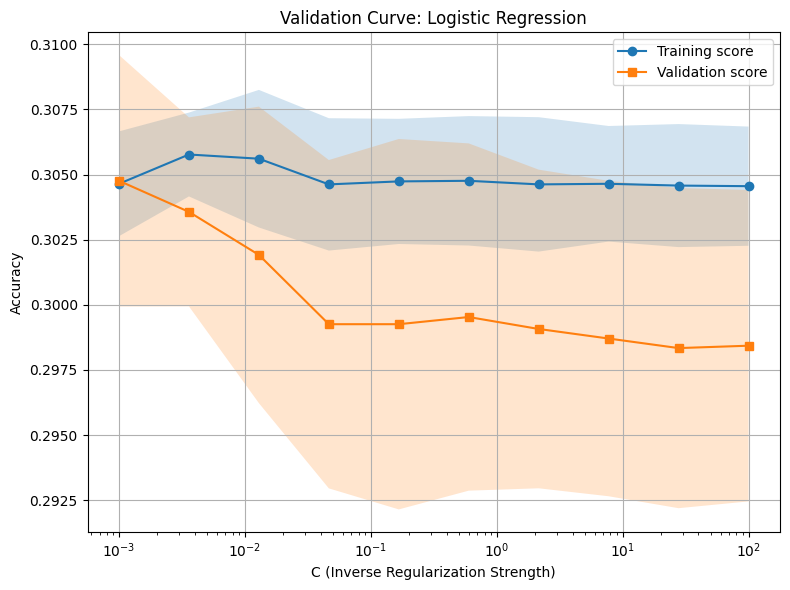

In [46]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Range of C values (log scale)
param_range = np.logspace(-3, 2, 10)

# Compute validation curve
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    X_scaled_reduced, le.fit_transform(y),
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Means and std for plotting
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.semilogx(param_range, train_mean, label='Training score', marker='o')
plt.semilogx(param_range, val_mean, label='Validation score', marker='s')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve: Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# Final Logistic Regression with best C
best_logreg = LogisticRegression(C=0.001, max_iter=1000,solver='lbfgs')
best_logreg.fit(X_train, y_train_enc)

# Evaluate
y_pred = best_logreg.predict(X_test)
from sklearn.metrics import accuracy_score
print("Tuned Logistic Regression Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Tuned Logistic Regression Accuracy: 0.2901


Degree 1 - Accuracy: 0.2906
Degree 2 - Accuracy: 0.2800
Degree 3 - Accuracy: 0.2938
Degree 4 - Accuracy: 0.2764
Degree 5 - Accuracy: 0.2731
Degree 6 - Accuracy: 0.2635
Degree 7 - Accuracy: 0.2608
Degree 8 - Accuracy: 0.2571
Degree 9 - Accuracy: 0.2603
Degree 10 - Accuracy: 0.2544


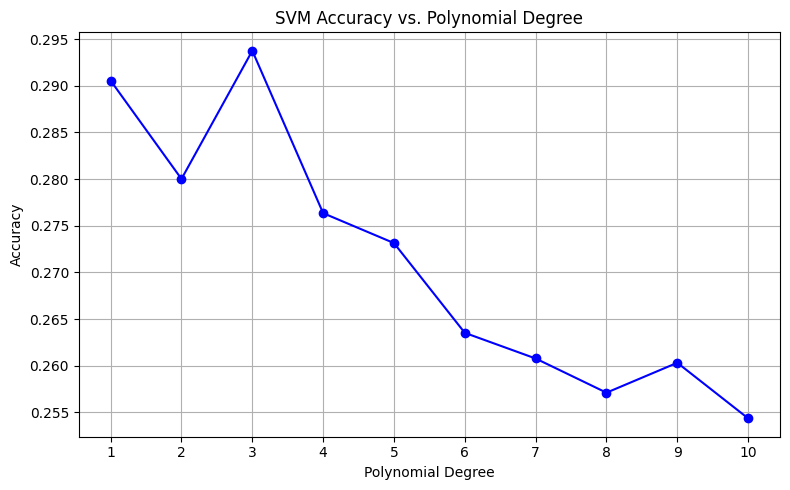

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

degrees = range(1, 11)
accuracies = []

for d in degrees:
    svm_poly = SVC(kernel='poly', degree=d, C=1.0, gamma='scale', decision_function_shape='ovr', random_state=42)
    svm_poly.fit(X_train, y_train_enc)
    y_pred = svm_poly.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"Degree {d} - Accuracy: {acc:.4f}")

# Plot accuracy vs. polynomial degree
plt.figure(figsize=(8, 5))
plt.plot(degrees, accuracies, marker='o', linestyle='-', color='blue')
plt.title("SVM Accuracy vs. Polynomial Degree")
plt.xlabel("Polynomial Degree")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(degrees)
plt.tight_layout()
plt.show()


k = 1, Accuracy = 0.2218
k = 2, Accuracy = 0.2172
k = 3, Accuracy = 0.2200
k = 4, Accuracy = 0.2319
k = 5, Accuracy = 0.2401
k = 6, Accuracy = 0.2282
k = 7, Accuracy = 0.2273
k = 8, Accuracy = 0.2397
k = 9, Accuracy = 0.2346
k = 10, Accuracy = 0.2328
k = 11, Accuracy = 0.2305
k = 12, Accuracy = 0.2415
k = 13, Accuracy = 0.2424
k = 14, Accuracy = 0.2314
k = 15, Accuracy = 0.2456
k = 16, Accuracy = 0.2475
k = 17, Accuracy = 0.2429
k = 18, Accuracy = 0.2498
k = 19, Accuracy = 0.2566
k = 20, Accuracy = 0.2562
k = 21, Accuracy = 0.2580
k = 22, Accuracy = 0.2553
k = 23, Accuracy = 0.2580
k = 24, Accuracy = 0.2534
k = 25, Accuracy = 0.2608
k = 26, Accuracy = 0.2589
k = 27, Accuracy = 0.2571
k = 28, Accuracy = 0.2603
k = 29, Accuracy = 0.2589
k = 30, Accuracy = 0.2594
k = 31, Accuracy = 0.2589
k = 32, Accuracy = 0.2603
k = 33, Accuracy = 0.2548
k = 34, Accuracy = 0.2599
k = 35, Accuracy = 0.2626
k = 36, Accuracy = 0.2631
k = 37, Accuracy = 0.2608
k = 38, Accuracy = 0.2663
k = 39, Accuracy = 0.

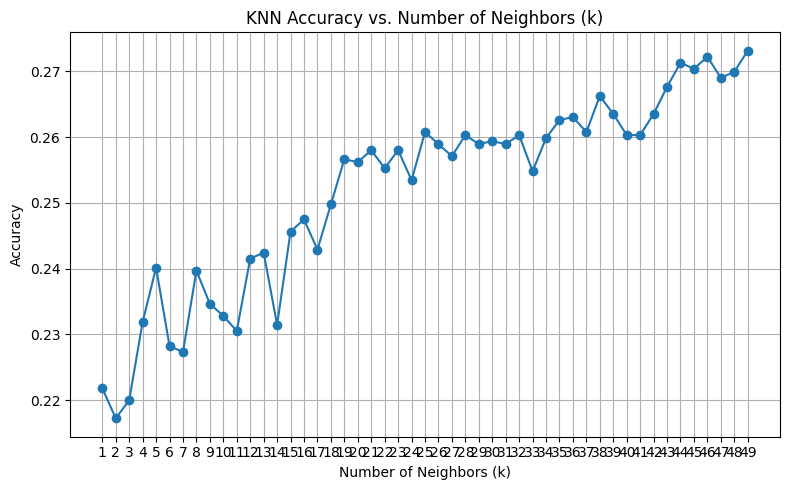

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try k values from 1 to 30
k_values = range(1, 50)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train_enc)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title("KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Final KNN model
best_knn = KNeighborsClassifier(n_neighbors=37)
best_knn.fit(X_train, y_train_enc)
y_pred = best_knn.predict(X_test)

# Evaluate
print("Final KNN Accuracy (k=37): %.4f" % accuracy_score(y_test_enc, y_pred))


Final KNN Accuracy (k=37): 0.2608


k = 1, Accuracy = 0.2218
k = 2, Accuracy = 0.2218
k = 3, Accuracy = 0.2301
k = 4, Accuracy = 0.2356
k = 5, Accuracy = 0.2475
k = 6, Accuracy = 0.2429
k = 7, Accuracy = 0.2406
k = 8, Accuracy = 0.2420
k = 9, Accuracy = 0.2438
k = 10, Accuracy = 0.2479
k = 11, Accuracy = 0.2456
k = 12, Accuracy = 0.2443
k = 13, Accuracy = 0.2429
k = 14, Accuracy = 0.2447
k = 15, Accuracy = 0.2479
k = 16, Accuracy = 0.2548
k = 17, Accuracy = 0.2521
k = 18, Accuracy = 0.2470
k = 19, Accuracy = 0.2576
k = 20, Accuracy = 0.2585
k = 21, Accuracy = 0.2594
k = 22, Accuracy = 0.2562
k = 23, Accuracy = 0.2534
k = 24, Accuracy = 0.2589
k = 25, Accuracy = 0.2571
k = 26, Accuracy = 0.2539
k = 27, Accuracy = 0.2562
k = 28, Accuracy = 0.2612
k = 29, Accuracy = 0.2580
k = 30, Accuracy = 0.2576
k = 31, Accuracy = 0.2599
k = 32, Accuracy = 0.2640
k = 33, Accuracy = 0.2585
k = 34, Accuracy = 0.2599
k = 35, Accuracy = 0.2626
k = 36, Accuracy = 0.2644
k = 37, Accuracy = 0.2603
k = 38, Accuracy = 0.2617
k = 39, Accuracy = 0.

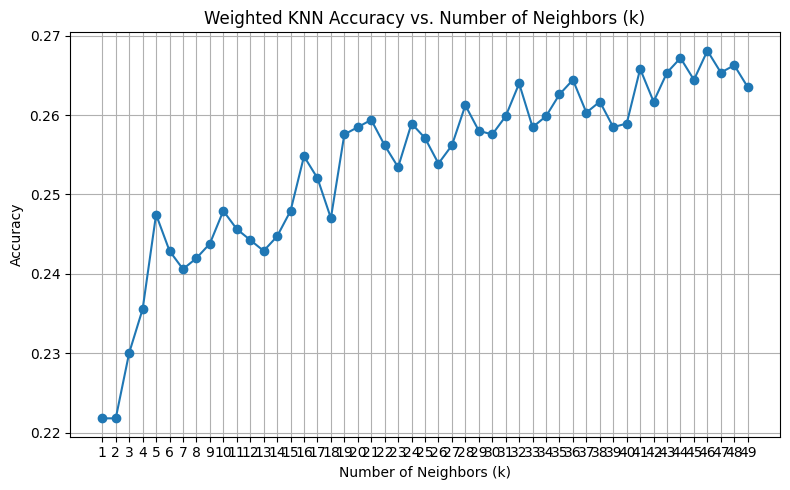

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Try k values from 1 to 50 with weighted distance
k_values = range(1, 50)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train_enc)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title("Weighted KNN Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [52]:
best_knn_weighted = KNeighborsClassifier(n_neighbors=34, weights='distance')
best_knn_weighted.fit(X_train, y_train_enc)
y_pred = best_knn_weighted.predict(X_test)

from sklearn.metrics import accuracy_score
print("Final Weighted KNN Accuracy (k=34): %.4f" % accuracy_score(y_test_enc, y_pred))


Final Weighted KNN Accuracy (k=34): 0.2599


max_depth=3, n_estimators=10 → Accuracy: 0.2942
max_depth=3, n_estimators=50 → Accuracy: 0.2933
max_depth=3, n_estimators=100 → Accuracy: 0.2938
max_depth=3, n_estimators=150 → Accuracy: 0.2947
max_depth=3, n_estimators=200 → Accuracy: 0.2951
max_depth=3, n_estimators=250 → Accuracy: 0.2956
max_depth=3, n_estimators=300 → Accuracy: 0.2956
max_depth=3, n_estimators=350 → Accuracy: 0.2951
max_depth=3, n_estimators=400 → Accuracy: 0.2951
max_depth=4, n_estimators=10 → Accuracy: 0.2887
max_depth=4, n_estimators=50 → Accuracy: 0.2938
max_depth=4, n_estimators=100 → Accuracy: 0.2938
max_depth=4, n_estimators=150 → Accuracy: 0.2961
max_depth=4, n_estimators=200 → Accuracy: 0.2947
max_depth=4, n_estimators=250 → Accuracy: 0.2956
max_depth=4, n_estimators=300 → Accuracy: 0.2951
max_depth=4, n_estimators=350 → Accuracy: 0.2951
max_depth=4, n_estimators=400 → Accuracy: 0.2961
max_depth=5, n_estimators=10 → Accuracy: 0.2961
max_depth=5, n_estimators=50 → Accuracy: 0.2970
max_depth=5, n_estimators=

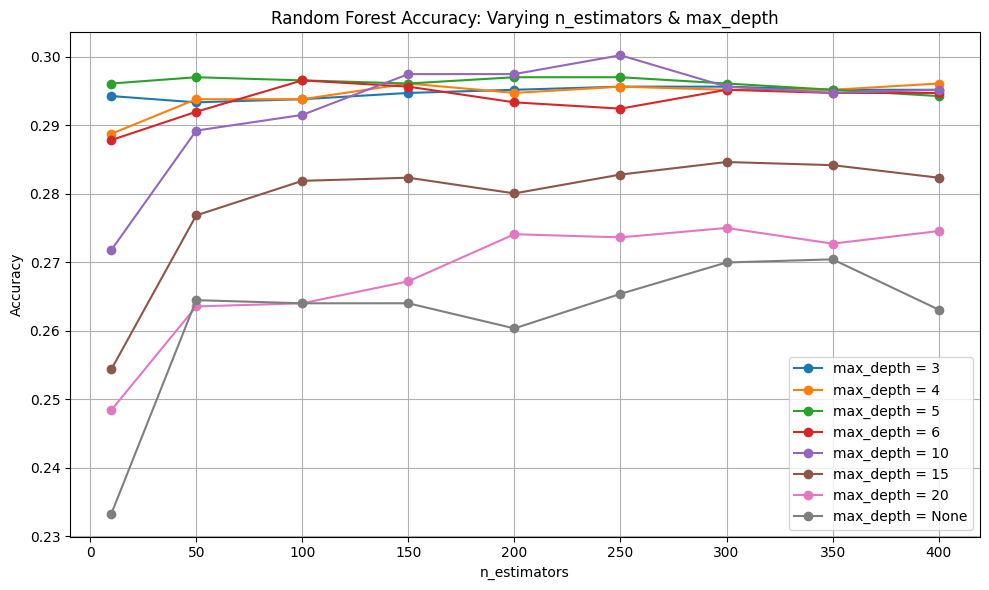

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Parameter ranges
n_estimators_range = [10,50, 100, 150, 200, 250,300,350,400]
max_depth_range = [3,4,5,6, 10, 15, 20, None]

# Store results
results = {}

# Evaluate all combinations
for depth in max_depth_range:
    acc_list = []
    for n in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train_enc)
        y_pred = rf.predict(X_test)
        acc = accuracy_score(y_test_enc, y_pred)
        acc_list.append(acc)
        print(f"max_depth={depth}, n_estimators={n} → Accuracy: {acc:.4f}")
    results[str(depth)] = acc_list

# Plotting
plt.figure(figsize=(10, 6))
for depth, accs in results.items():
    label = f"max_depth = {depth}"
    plt.plot(n_estimators_range, accs, marker='o', label=label)

plt.title("Random Forest Accuracy: Varying n_estimators & max_depth")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Best RF model
rf_final = RandomForestClassifier(
    n_estimators=350,
    max_depth=4,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_train, y_train_enc)
y_pred = rf_final.predict(X_test)

print("Final Random Forest Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final Random Forest Accuracy: 0.2951


C = 0.01, Accuracy = 0.2974
C = 0.10, Accuracy = 0.2965
C = 0.50, Accuracy = 0.2965
C = 1.00, Accuracy = 0.2929
C = 2.00, Accuracy = 0.2896
C = 5.00, Accuracy = 0.2805


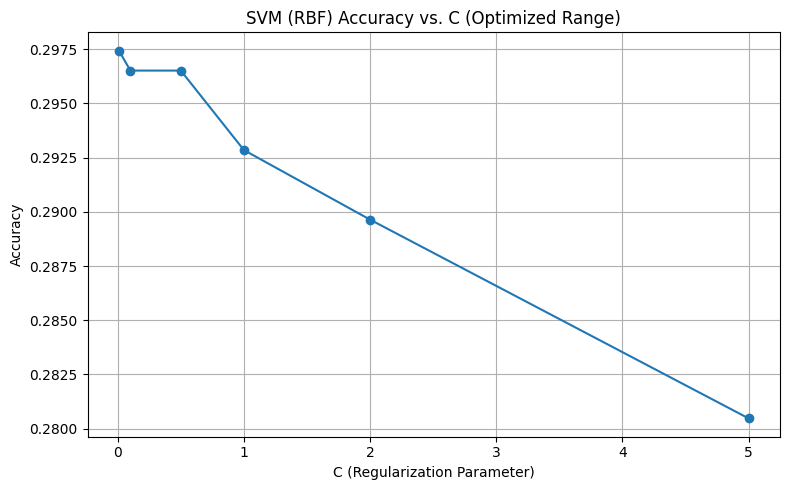

In [55]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Smarter C range
c_values = [0.01, 0.1, 0.5, 1, 2, 5]
accuracies = []

for c in c_values:
    svm_model = SVC(kernel='rbf', C=c, gamma='scale', decision_function_shape='ovr', random_state=42)
    svm_model.fit(X_train, y_train_enc)
    y_pred = svm_model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"C = {c:.2f}, Accuracy = {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(c_values, accuracies, marker='o', linestyle='-')
plt.title("SVM (RBF) Accuracy vs. C (Optimized Range)")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

final_svm = SVC(kernel='rbf', C=0.01, gamma='scale', decision_function_shape='ovr', random_state=42)
final_svm.fit(X_train, y_train_enc)
y_pred = final_svm.predict(X_test)

print("Final Tuned SVM Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final Tuned SVM Accuracy: 0.2974


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=100 → Accuracy: 0.2855


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=200 → Accuracy: 0.2851


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.01, n_estimators=300 → Accuracy: 0.2809


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=100 → Accuracy: 0.2814


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=200 → Accuracy: 0.2764


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.05, n_estimators=300 → Accuracy: 0.2773


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=100 → Accuracy: 0.2773


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=200 → Accuracy: 0.2695


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.1, n_estimators=300 → Accuracy: 0.2644


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=100 → Accuracy: 0.2686


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=200 → Accuracy: 0.2690


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:12:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


learning_rate=0.2, n_estimators=300 → Accuracy: 0.2498


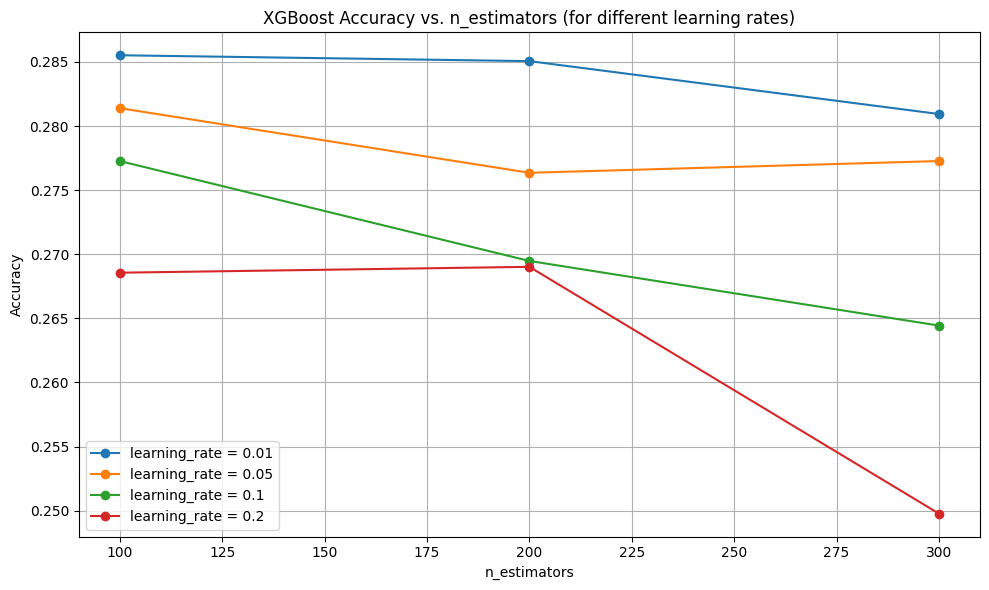

In [57]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Parameters to test
learning_rates = [0.01, 0.05, 0.1, 0.2]
n_estimators_range = [100, 200, 300]

# Store results
results = {}

for lr in learning_rates:
    accs = []
    for n in n_estimators_range:
        model = XGBClassifier(
            learning_rate=lr,
            n_estimators=n,
            max_depth=6,
            use_label_encoder=False,
            eval_metric='mlogloss',
            random_state=42
        )
        model.fit(X_train, y_train_enc)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test_enc, y_pred)
        accs.append(acc)
        print(f"learning_rate={lr}, n_estimators={n} → Accuracy: {acc:.4f}")
    results[str(lr)] = accs

# Plotting
plt.figure(figsize=(10, 6))
for lr, accs in results.items():
    plt.plot(n_estimators_range, accs, marker='o', label=f"learning_rate = {lr}")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("XGBoost Accuracy vs. n_estimators (for different learning rates)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

final_xgb = XGBClassifier(
    learning_rate=0.01,
    n_estimators=300,
    max_depth=6,
    eval_metric='mlogloss',
    random_state=42
)
final_xgb.fit(X_train, y_train_enc)
y_pred = final_xgb.predict(X_test)

print("Final XGBoost Accuracy: %.4f" % accuracy_score(y_test_enc, y_pred))


Final XGBoost Accuracy: 0.2809


SVM Only → Accuracy: 0.2956
SVM + RF → Accuracy: 0.2988
SVM + RF + XGB → Accuracy: 0.2929


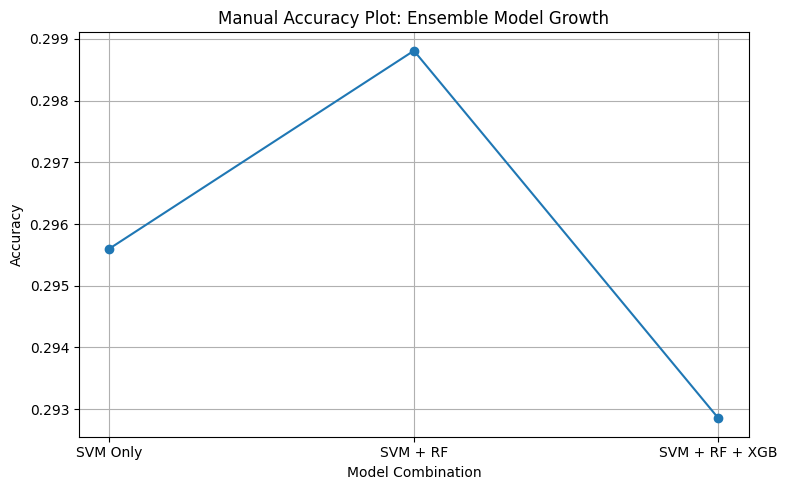

In [59]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Base models
svm_final = SVC(kernel='rbf', C=0.01, gamma='scale', probability=True, random_state=42)
rf_final = RandomForestClassifier(n_estimators=350, max_depth=4, random_state=42)
xgb_final = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=6, eval_metric='mlogloss', random_state=42)

# Define model groups to test
model_sets = [
    [('svm', svm_final)],
    [('svm', svm_final), ('rf', rf_final)],
    [('svm', svm_final), ('rf', rf_final), ('xgb', xgb_final)]
]

labels = ['SVM Only', 'SVM + RF', 'SVM + RF + XGB']
accuracies = []

# Evaluate each ensemble configuration
for label, models in zip(labels, model_sets):
    ensemble = VotingClassifier(estimators=models, voting='soft')
    ensemble.fit(X_train, y_train_enc)
    y_pred = ensemble.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"{label} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Manual Accuracy Plot: Ensemble Model Growth")
plt.xlabel("Model Combination")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


SVM Only (Stack) → Accuracy: 0.3025
SVM + RF (Stack) → Accuracy: 0.2979
SVM + RF + XGB (Stack) → Accuracy: 0.2965


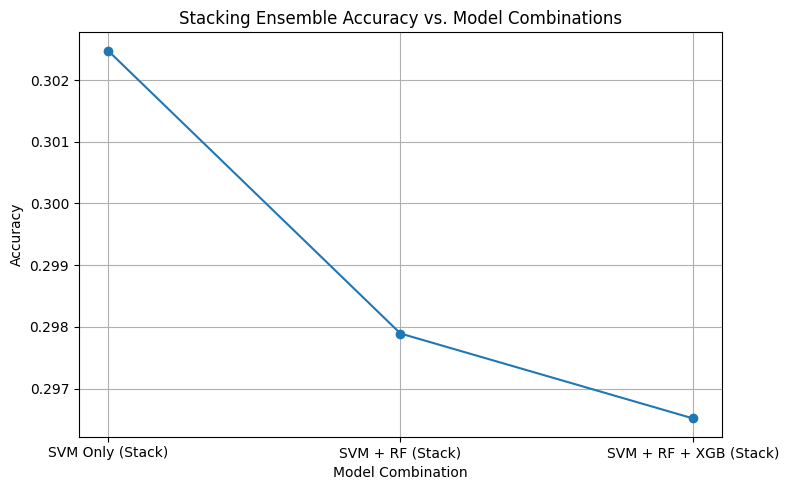

In [60]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Base models
svm_model = SVC(kernel='rbf', C=0.01, gamma='scale', probability=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=350, max_depth=4, random_state=42)
xgb_model = XGBClassifier(learning_rate=0.01, n_estimators=300, max_depth=6, eval_metric='mlogloss', random_state=42)

# Meta-model
meta_model = LogisticRegression(max_iter=1000)

# Model sets
model_sets = [
    [('svm', svm_model)],
    [('svm', svm_model), ('rf', rf_model)],
    [('svm', svm_model), ('rf', rf_model), ('xgb', xgb_model)]
]

labels = ['SVM Only (Stack)', 'SVM + RF (Stack)', 'SVM + RF + XGB (Stack)']
accuracies = []

# Evaluate stacking models
for label, base_models in zip(labels, model_sets):
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=False,  # use base model predictions only
        cv=5,
        n_jobs=-1
    )
    stack.fit(X_train, y_train_enc)
    y_pred = stack.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"{label} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Stacking Ensemble Accuracy vs. Model Combinations")
plt.xlabel("Model Combination")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Architecture (50,) → Accuracy: 0.2640


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (100,) → Accuracy: 0.2571


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (150,) → Accuracy: 0.2479


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (100, 50) → Accuracy: 0.2356


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (128, 64) → Accuracy: 0.2324


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Architecture (128, 64, 32) → Accuracy: 0.2204
Architecture (256, 128, 64) → Accuracy: 0.2026


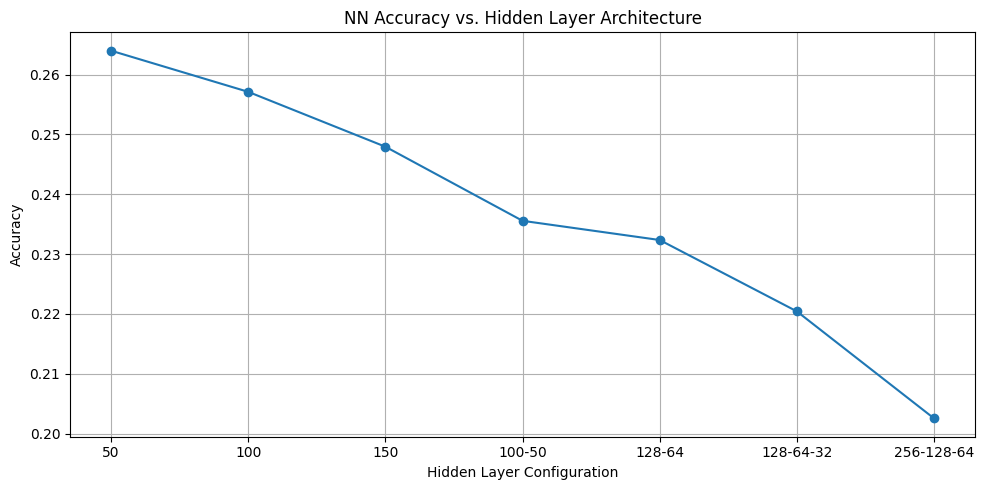

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define architectures to test
architectures = [
    (50,),
    (100,),
    (150,),
    (100, 50),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64)
]

labels = ['50', '100', '150', '100-50', '128-64', '128-64-32', '256-128-64']
accuracies = []

# Train and evaluate each
for arch in architectures:
    nn = MLPClassifier(hidden_layer_sizes=arch, max_iter=300, random_state=42)
    nn.fit(X_train, y_train_enc)
    y_pred = nn.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    accuracies.append(acc)
    print(f"Architecture {arch} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("NN Accuracy vs. Hidden Layer Architecture")
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Architecture (64,) → Accuracy: 0.2676
Architecture (128,) → Accuracy: 0.2635
Architecture (128, 64) → Accuracy: 0.2580
Architecture (128, 64, 32) → Accuracy: 0.2525
Architecture (256, 128, 64) → Accuracy: 0.2379


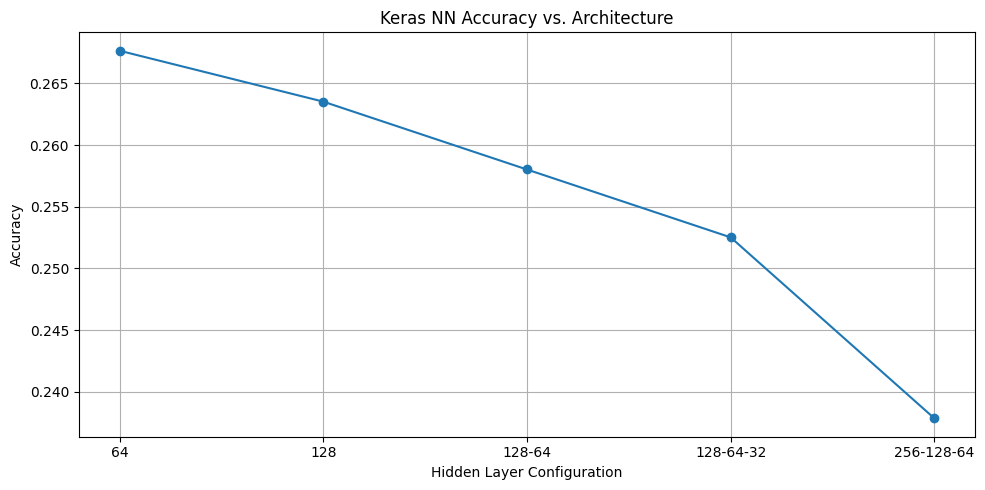

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure y is one-hot encoded
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Define different architectures to test
architectures = [
    (64,),
    (128,),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64)
]

labels = ['64', '128', '128-64', '128-64-32', '256-128-64']
accuracies = []

# Loop through each architecture
for arch in architectures:
    model = Sequential()
    model.add(Dense(arch[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    for units in arch[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train_cat, epochs=30, batch_size=32, verbose=0)  # no validation for simplicity
    
    loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"Architecture {arch} → Accuracy: {acc:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Keras NN Accuracy vs. Architecture")
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


Architecture (64,) with dropout+BN → Accuracy: 0.2906
Architecture (128,) with dropout+BN → Accuracy: 0.2929
Architecture (128, 64) with dropout+BN → Accuracy: 0.2819
Architecture (128, 64, 32) with dropout+BN → Accuracy: 0.2814
Architecture (256, 128, 64) with dropout+BN → Accuracy: 0.2869


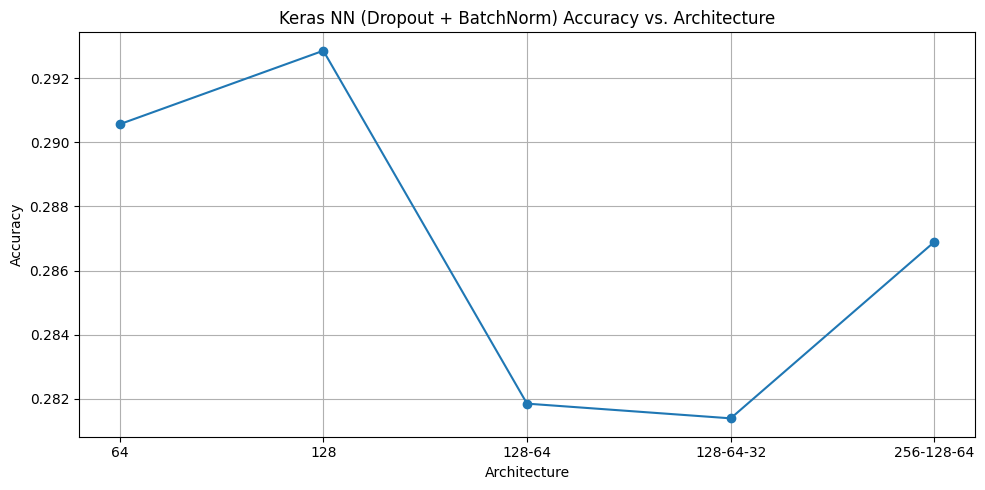

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Architectures
architectures = [
    (64,),
    (128,),
    (128, 64),
    (128, 64, 32),
    (256, 128, 64)
]
labels = ['64', '128', '128-64', '128-64-32', '256-128-64']
accuracies = []

# Loop and evaluate
for arch in architectures:
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    for i, units in enumerate(arch):
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())       # Normalize output
        model.add(Dropout(0.3))               # Drop 30% of neurons

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train_cat, epochs=30, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"Architecture {arch} with dropout+BN → Accuracy: {acc:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-')
plt.title("Keras NN (Dropout + BatchNorm) Accuracy vs. Architecture")
plt.xlabel("Architecture")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Build model (best: 128-64-32)
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Tuned Keras Model Accuracy (EarlyStopping + LR Scheduler): %.4f" % acc)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2274 - loss: 2.0787 - val_accuracy: 0.2854 - val_loss: 1.5737 - learning_rate: 0.0010
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2625 - loss: 1.7080 - val_accuracy: 0.2774 - val_loss: 1.5562 - learning_rate: 0.0010
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2707 - loss: 1.6214 - val_accuracy: 0.2963 - val_loss: 1.5482 - learning_rate: 0.0010
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2831 - loss: 1.5892 - val_accuracy: 0.2900 - val_loss: 1.5460 - learning_rate: 0.0010
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2940 - loss: 1.5667 - val_accuracy: 0.2963 - val_loss: 1.5438 - learning_rate: 0.0010
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2934 - loss: 1.5620 - val_accuracy: 0.2946 - val_loss: 1.5454 - learning_rate: 0.0010
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3079 - loss: 1.

In [65]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Reshape input to 3D (samples, features, 1 channel)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_reshaped, y_train_cat, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("CNN Accuracy (1D): %.4f" % acc)


Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2406 - loss: 1.8204 - val_accuracy: 0.2350 - val_loss: 1.5949
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2843 - loss: 1.5664 - val_accuracy: 0.2579 - val_loss: 1.5627
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2955 - loss: 1.5545 - val_accuracy: 0.2791 - val_loss: 1.5487
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3066 - loss: 1.5250 - val_accuracy: 0.2888 - val_loss: 1.5557
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3140 - loss: 1.5330 - val_accuracy: 0.2848 - val_loss: 1.5533
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3141 - loss: 1.5335 - val_accuracy: 0.2860 - val_loss: 1.5492
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3262 - loss: 1.5273 - val_accuracy: 0.2774 - val_loss: 1.5523
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3200 - loss: 1.5113 - val_accuracy: 0.

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Reshape input to 3D for Conv1D
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build simplified, regularized CNN
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    X_train_reshaped, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test_reshaped, y_test_cat, verbose=0)
print("Simplified CNN Accuracy: %.4f" % acc)


Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2496 - loss: 2.0326 - val_accuracy: 0.2877 - val_loss: 1.6795
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2858 - loss: 1.6738 - val_accuracy: 0.2957 - val_loss: 1.6470
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2974 - loss: 1.6490 - val_accuracy: 0.2865 - val_loss: 1.6470
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3138 - loss: 1.6360 - val_accuracy: 0.2963 - val_loss: 1.6320
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3084 - loss: 1.6202 - val_accuracy: 0.3095 - val_loss: 1.6255
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3027 - loss: 1.6128 - val_accuracy: 0.2974 - val_loss: 1.6220
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3115 - loss: 1.6084 - val_accuracy: 0.2963 - val_loss: 1.6055
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3076 - loss: 1.6005 - val_accu

In [67]:
import numpy as np

def tabular_to_image(X, image_size=(8, 8)):
    padded = np.zeros((X.shape[0], image_size[0] * image_size[1]))
    padded[:, :X.shape[1]] = X  # pad with zeros if needed
    return padded.reshape((X.shape[0], image_size[0], image_size[1], 1))
X_train_img = tabular_to_image(X_train)
X_test_img = tabular_to_image(X_test)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Build CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_img, y_train_cat, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test_img, y_test_cat, verbose=0)
print("Grayscale CNN Accuracy (8x8 images): %.4f" % acc)



Epoch 1/30


c:\Users\Sajjad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2253 - loss: 1.7258 - val_accuracy: 0.2785 - val_loss: 1.5687
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2624 - loss: 1.5835 - val_accuracy: 0.2877 - val_loss: 1.5595
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2857 - loss: 1.5588 - val_accuracy: 0.2785 - val_loss: 1.5566
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2993 - loss: 1.5445 - val_accuracy: 0.2900 - val_loss: 1.5500
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3066 - loss: 1.5424 - val_accuracy: 0.2854 - val_loss: 1.5519
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2995 - loss: 1.5438 - val_accuracy: 0.2854 - val_loss: 1.5516
Epoch 7/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3093 - loss: 1.5331 - val_accuracy: 0.2951 - val_loss: 1.5489
Epoch 8/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3011 - loss: 1.5353 - val_accuracy: 0.2854 - val_

conv32 → Accuracy: 0.2621
conv32-dropout → Accuracy: 0.2956
conv32+64 → Accuracy: 0.2901
conv32+64-dropout → Accuracy: 0.2947
conv64+128-dropout → Accuracy: 0.2993


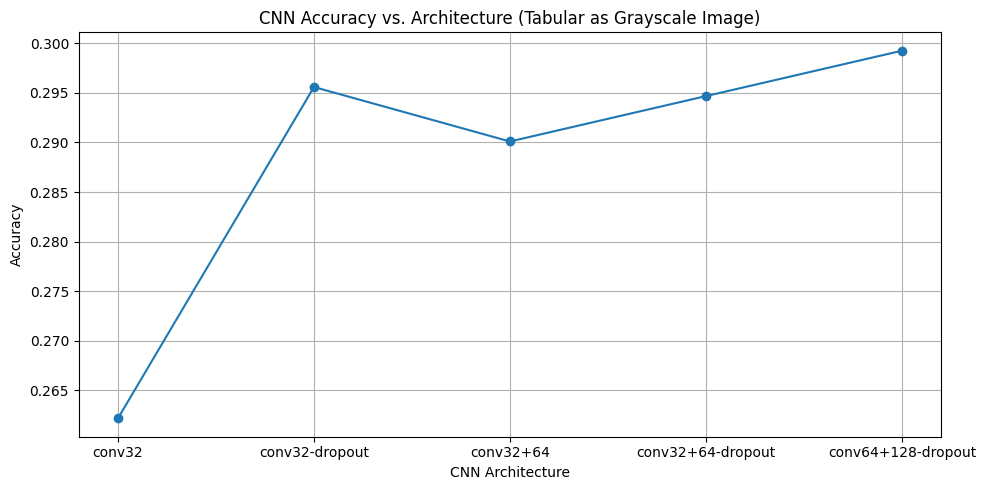

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Make sure data is ready
X_train_img = tabular_to_image(X_train)
X_test_img = tabular_to_image(X_test)

# One-hot encode labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Define architectures to test
architectures = [
    'conv32',
    'conv32-dropout',
    'conv32+64',
    'conv32+64-dropout',
    'conv64+128-dropout'
]
accuracies = []

# Evaluate each architecture
for name in architectures:
    model = Sequential()
    model.add(Input(shape=(8, 8, 1)))

    if name == 'conv32':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
    
    elif name == 'conv32-dropout':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Flatten())
        model.add(Dropout(0.3))
    
    elif name == 'conv32+64':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())

    elif name == 'conv32+64-dropout':
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dropout(0.3))

    elif name == 'conv64+128-dropout':
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train_img, y_train_cat, epochs=20, batch_size=32, verbose=0)
    loss, acc = model.evaluate(X_test_img, y_test_cat, verbose=0)
    accuracies.append(acc)
    print(f"{name} → Accuracy: {acc:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(architectures, accuracies, marker='o', linestyle='-')
plt.title("CNN Accuracy vs. Architecture (Tabular as Grayscale Image)")
plt.xlabel("CNN Architecture")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
def tabular_to_images_224(X):
    images = []
    for row in X:
        flat = np.zeros(224 * 224)
        flat[:len(row)] = row
        image_gray = flat.reshape((224, 224)).astype(np.uint8)
        image_rgb = np.stack([image_gray] * 3, axis=-1)
        images.append(image_rgb)
    return np.array(images)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Convert tabular data to image format
X_train_img = tabular_to_images_224(X_train)
X_test_img = tabular_to_images_224(X_test)

# Preprocess for MobileNetV2
X_train_img = preprocess_input(X_train_img.astype('float32'))
X_test_img = preprocess_input(X_test_img.astype('float32'))

# Labels
num_classes = len(np.unique(y_train_enc))
y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_test_cat = to_categorical(y_test_enc, num_classes=num_classes)

# Load model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
X_train_feat = feature_model.predict(X_train_img, batch_size=32, verbose=1)
X_test_feat = feature_model.predict(X_test_img, batch_size=32, verbose=1)

# Flatten for classifier
X_train_flat = X_train_feat.reshape((X_train_feat.shape[0], -1))
X_test_flat = X_test_feat.reshape((X_test_feat.shape[0], -1))

# Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_flat, y_train_enc)
y_pred = clf.predict(X_test_flat)
acc = accuracy_score(y_test_enc, y_pred)

print("MobileNetV2 Transfer Learning Accuracy: %.4f" % acc)


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5: 403 -- Forbidden